Hello this is Jensen's branch

In [218]:
!pip install numpy; random; matplotlib; scipy

zsh:1: command not found: random
zsh:1: command not found: matplotlib
zsh:1: command not found: scipy


In [219]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [220]:
rng = rng = np.random.default_rng(seed=42)

In [221]:
import numpy as np

def gillespie(initial, beta, gamma, mu, max_time, rng):
    S, I, R = initial

    # initialize
    SIR_states = [[S, I, R]]
    timestamps = [0.0]

    events = np.array([
        [ 1,  0,  0],   # Birth
        [-1, +1,  0],   # Infection
        [ 0, -1, +1],   # Recovery
        [-1,  0,  0],   # Death S
        [ 0, -1,  0],   # Death I
        [ 0,  0, -1]    # Death R
    ])

    while timestamps[-1] < max_time and (S+I+R) > 0:
        N = S + I + R

        event_rates = np.array([
            mu * N,
            beta * S*I/N if N > 0 else 0,
            gamma * I,
            mu * S,
            mu * I,
            mu * R
        ])

        # Draw random uniforms for each event
        U = rng.random(len(event_rates))

        # Compute waiting times (τ_i = -log(U_i)/rate_i)
        dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)

        dt_min = np.min(dt_list)
        event = np.argmin(dt_list)

        if dt_min == np.inf:
            break

        # Update time
        timestamps.append(timestamps[-1] + dt_min)

        # Update state
        dS, dI, dR = events[event]
        S, I, R = max(0, S+dS), max(0, I+dI), max(0, R+dR)

        SIR_states.append([S,I,R])

    return np.array(timestamps), np.array(SIR_states)


In [222]:
def SIR_demography(y, t, N, beta, gamma, mu):
    '''SIR model with demography'''
    
    dSdt = mu - beta*y[0]*y[1] - mu*y[0]
    dIdt = beta*y[0]*y[1] - gamma*y[1] - mu*y[1]
    dRdt = gamma*y[1] - mu*y[2]
    
    return [dSdt, dIdt, dRdt]

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_77490/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


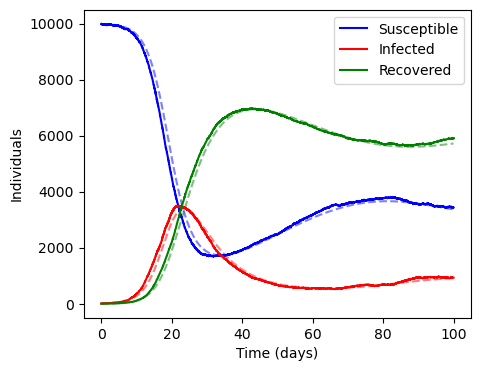

In [223]:
# Define population parameters
N = 10000
I0 = 10

# Define model parameters
beta = 1/2
gamma = 1/7
mu = 0.02

# Duration of simulation
days = 100

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]
event_rates = [mu, beta, gamma, mu, mu, mu]

# Run gillepsie algorithm
time, values = gillespie(initial, beta, gamma, mu, 100, rng)

# Gather values over time for each compartment
susceptible = [event[0] for event in values]
infected = [event[1] for event in values]
recovered = [event[2] for event in values]

# Inital parameters deterministic model
y0 = [(N-I0)/N, I0/N, 0]

# Determine timesteps and resolution
t = np.linspace(0, days, 1001)

# Get deteministic solution
solution = odeint(SIR_demography, y0, t, args=(N, beta, gamma, mu))

# Plot data
fig = plt.figure(figsize=(5,4))

# Plot deteministic model
plt.plot(t, solution[:,0] * 10000,'b--', alpha=0.5)
plt.plot(t, solution[:,1] * 10000,'r--', alpha=0.5)
plt.plot(t, solution[:,2] * 10000,'g--', alpha=0.5)

# Plot gillepsie model
plt.plot(time, susceptible, 'b-', label=r'Susceptible')
plt.plot(time, infected, 'r-', label=r'Infected')
plt.plot(time, recovered, 'g-', label=r'Recovered')

plt.ylabel('Individuals')
plt.xlabel('Time (days)')
plt.legend(loc='best')
plt.show()

In [239]:
def gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng):
    # initialize lists 
    all_S, all_I =  [], []
    initial = [N-I0, I0, 0]
    y0 = [(N-I0)/N, I0/N, 0]
    
    interpolation_grid = np.linspace(0, max_time, 1000)
    results = []

    for gamma in gammas:
        for beta in betas:
            run_S, run_I = [], []

            for _ in range(n_runs):
                t, SIR = gillespie(initial, beta, gamma, mu, max_time, rng)
                S, I, R = SIR.T

                # Interpolate to common time grid
                S_interp = np.interp(interpolation_grid, t, S)
                I_interp = np.interp(interpolation_grid, t, I)

                run_S.append(S_interp)
                run_I.append(I_interp)
    
            # stochastic solutions
            all_S = np.array(run_S)
            all_I = np.array(run_I)

            # deterministic solutions
            solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu))
            S_d, I_d, R = solution.T
            results.append((beta, gamma, all_S, all_I, S_d, I_d))
    
    return results, interpolation_grid
              

In [240]:
def compute_means(all_S, all_I):
    all_S, all_I = np.array(all_S), np.array(all_I)
    I_mean = all_I.mean(axis=0)
    S_mean = all_S.mean(axis=0)
    I_var = all_I.var(axis=0)
    cov_SI = np.mean((all_S - S_mean) * (all_I - I_mean), axis=0)
    return I_mean, S_mean, I_var, cov_SI

In [241]:
rng = np.random.default_rng(42)

# Parameters
I0 = 10
N  = 1000
# define variable variation
betas = [0.5, 1.0, 2.0, 4.0, 5.0]
gammas = [0.1, 0.5]
mu = 1/40
n_runs = 10
max_time = 50

## Intuition ##
As $R0$ grows, the negative covariance between $I(t)$ and $S(t)$ shrinks due to different parametrical settings of $\beta$ and $\gamma$,

### stochastic resonance ###


In [242]:
def plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs):
    I_mean, S_mean, I_var, cov_SI = compute_means(all_S, all_I)

    plt.figure(figsize=(10, 5))
    for S in all_S:
        plt.plot(interpolation_grid, S, color='black', alpha=0.2)
    for I_run in all_I:
        plt.plot(interpolation_grid, I_run, color='gray', alpha=0.2)

    plt.plot(interpolation_grid, I_mean, color='red', lw=2, label='Mean I(t)')
    plt.fill_between(interpolation_grid,
                     I_mean - np.sqrt(I_var),
                     I_mean + np.sqrt(I_var),
                     color='tab:orange', alpha=0.3, label='±1 Std Dev')
    plt.plot(interpolation_grid, S_mean, color='blue', lw=2, label='Mean S(t)')

    plt.plot(interpolation_grid, S_d * N, 'b--', lw=2, label='S(t) deterministic')
    plt.plot(interpolation_grid, I_d * N, 'r--', lw=2, label='I(t) deterministic')

    plt.xlabel("Time")
    plt.ylabel("Individuals")
    plt.title(f"Stochastic Gillespie (β={beta}, γ={gamma}, runs={n_runs})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cov_value = np.cov(S_mean, I_mean)[0, 1]
    print(f"β={beta}, γ={gamma}: Cov(S,I) = {cov_value:.4f}")


/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_77490/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


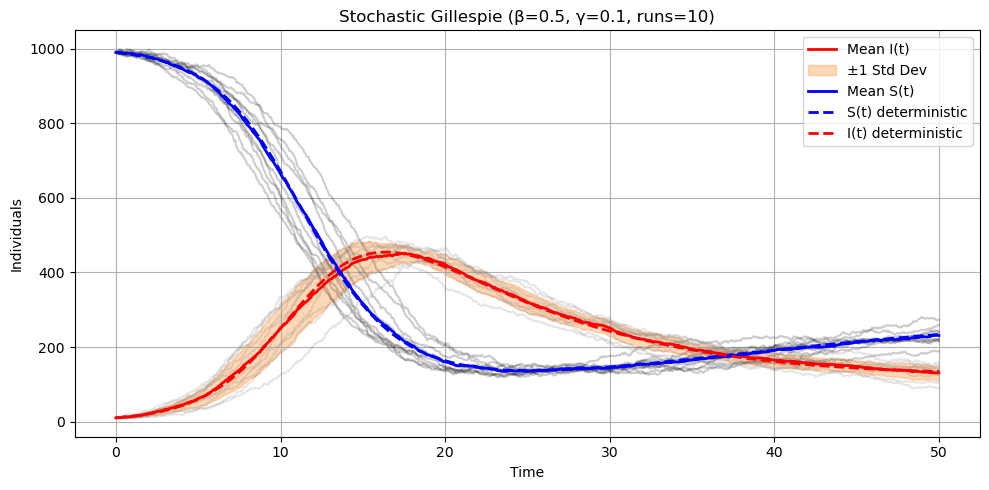

β=0.5, γ=0.1: Cov(S,I) = -19014.0937


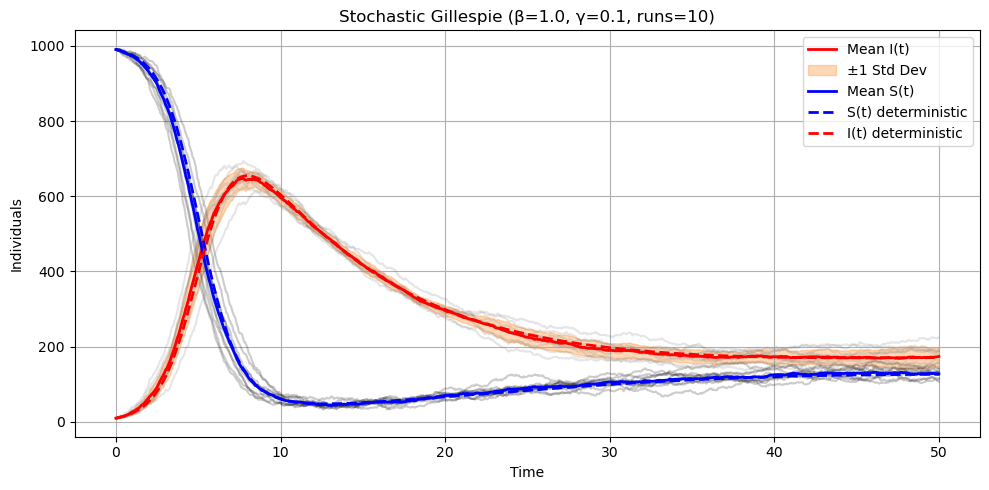

β=1.0, γ=0.1: Cov(S,I) = -11849.5695


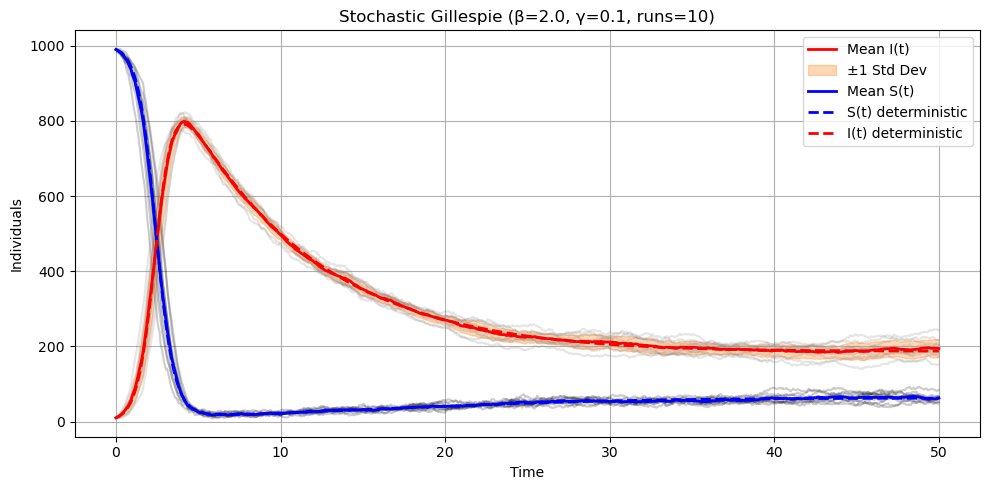

β=2.0, γ=0.1: Cov(S,I) = -6878.3863


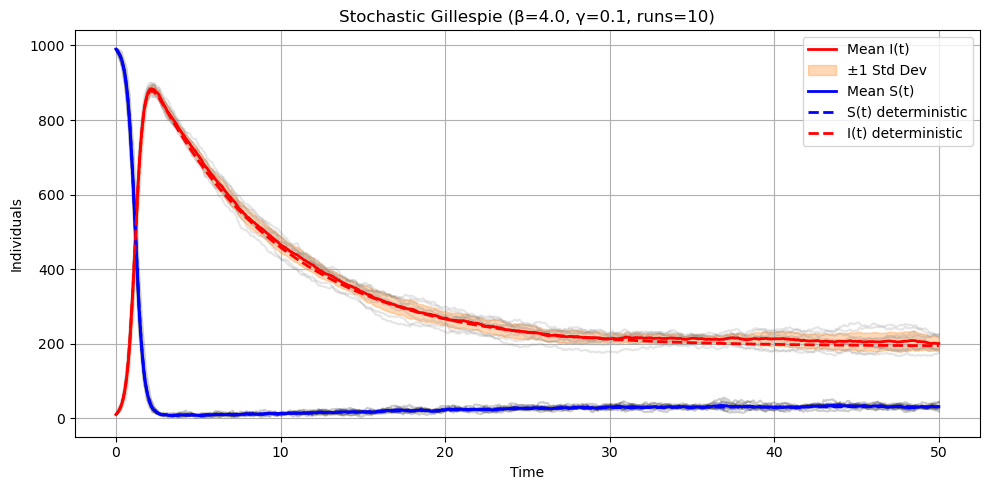

β=4.0, γ=0.1: Cov(S,I) = -4108.9200


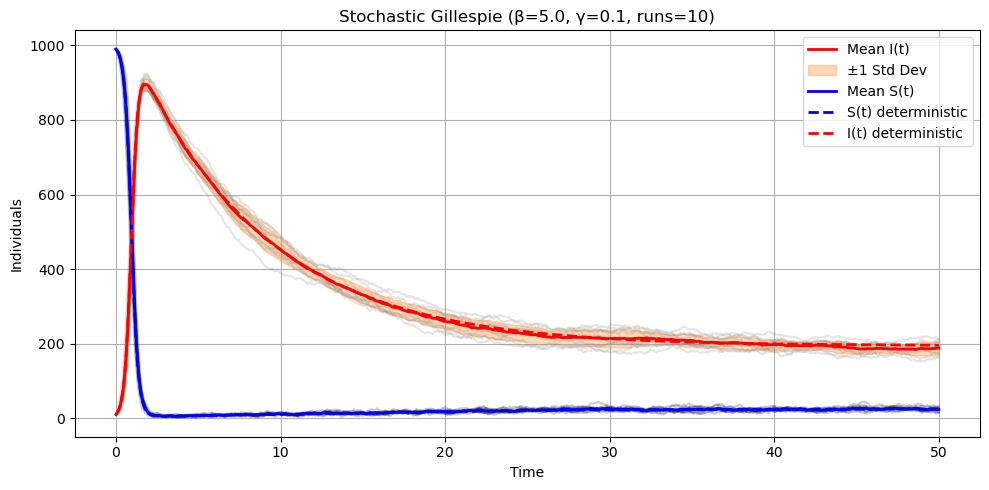

β=5.0, γ=0.1: Cov(S,I) = -3100.9374


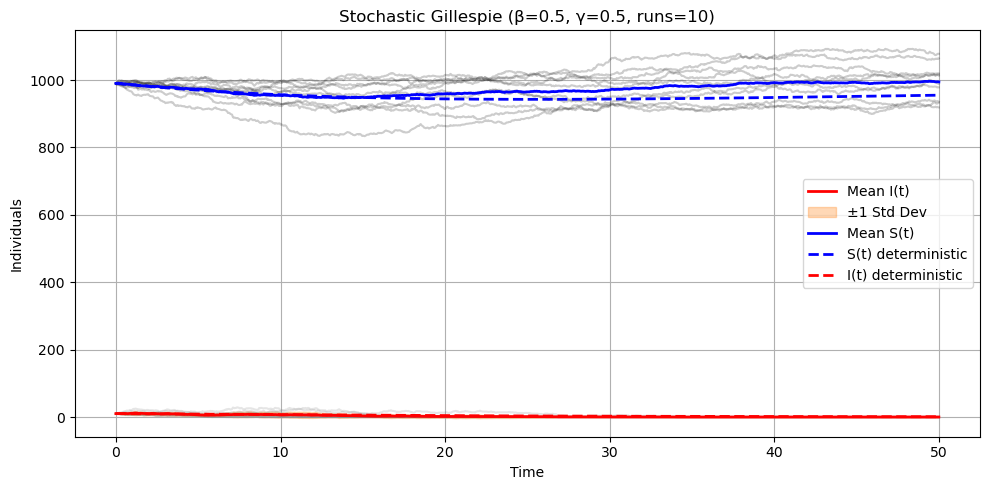

β=0.5, γ=0.5: Cov(S,I) = -17.5153


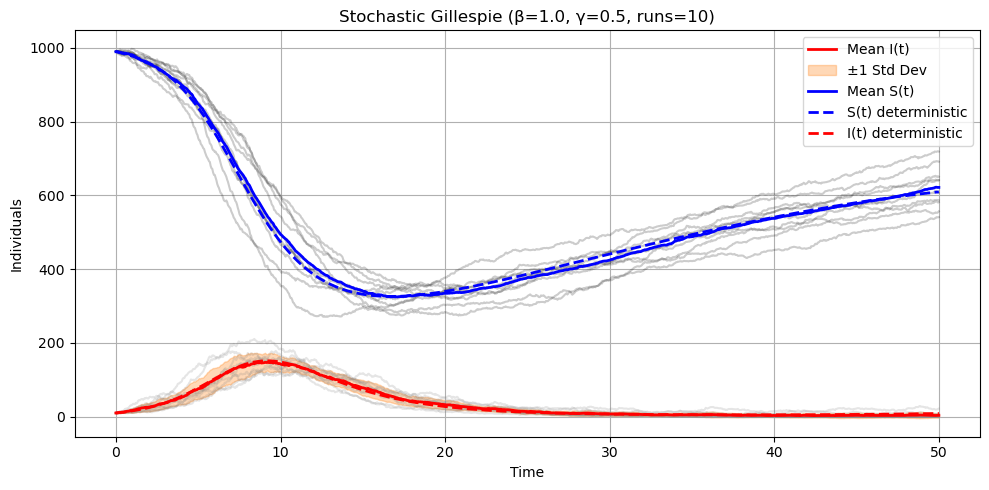

β=1.0, γ=0.5: Cov(S,I) = 232.8750


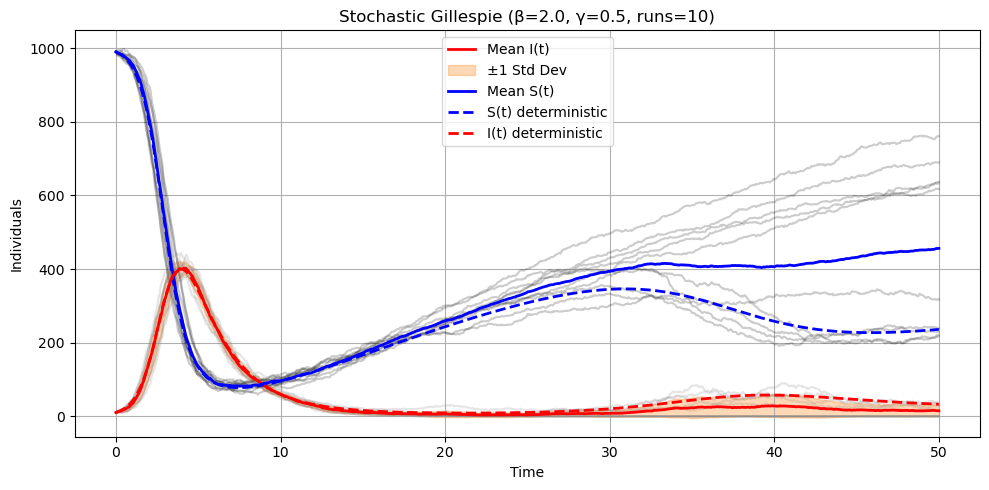

β=2.0, γ=0.5: Cov(S,I) = -2417.8523


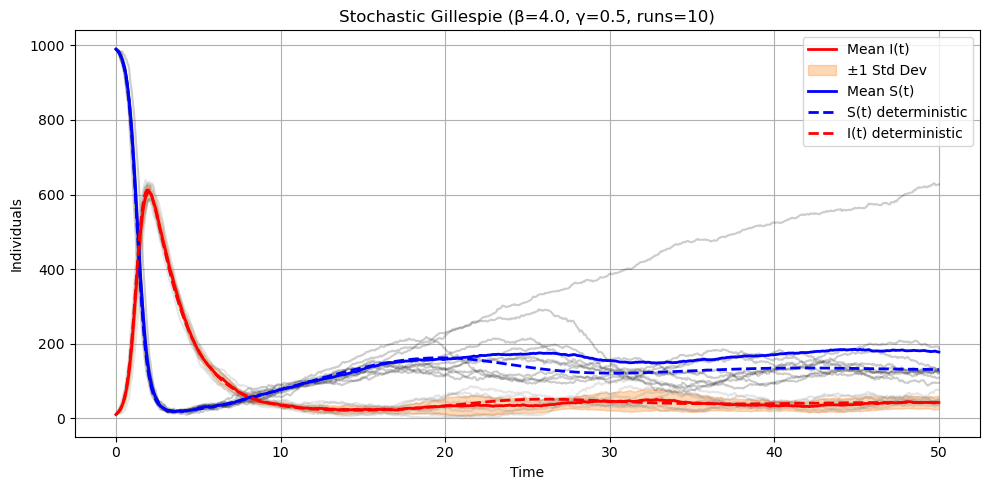

β=4.0, γ=0.5: Cov(S,I) = -967.6300


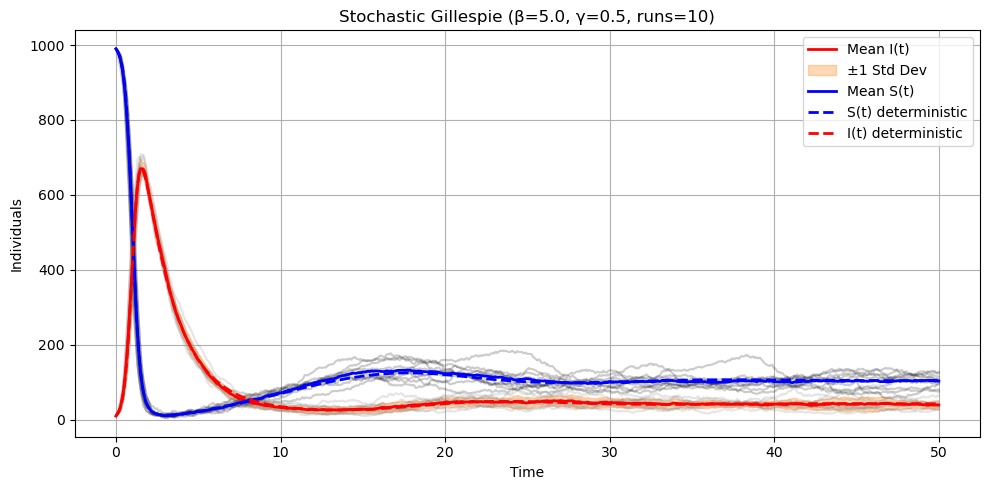

β=5.0, γ=0.5: Cov(S,I) = -292.6065


In [245]:
rng = np.random.default_rng(42)
I0 = 10
N = 1000
betas = [0.5, 1.0, 2.0, 4.0, 5.0]
gammas = [0.1, 0.5]
mu = 1/40
n_runs = 10
max_time = 50

results, interpolation_grid = gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng)

for beta, gamma, all_S, all_I, S_d, I_d in results:
    plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs)


## Stochastic resonance functions ##
The functions for varying variables among N, mu, beta, gamma

In [308]:
def stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for N_val in N_values:
        initial = [N_val - I0, I0, 0]
        y0 = [(N_val - I0) / N_val, I0 / N_val, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N_val, beta, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((N_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [309]:
def stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for beta_val in beta_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta_val, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta_val, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((beta_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [310]:
def stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for gamma_val in gamma_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma_val, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma_val, mu))
        S_d, I_d, R_d = solution.T

        results.append((gamma_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [311]:
def stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for mu_val in mu_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu_val, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu_val))
        S_d, I_d, R_d = solution.T

        results.append((mu_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [314]:
def plot_stochastic_resonance(results, interpolation_grid, base_N, base_beta, base_gamma, base_mu, vary):
    """
    Plot time series of stochastic SIR simulations for different parameter values.
    Works with results from stochastic_resonance_N, _beta, _gamma, or _mu.
    """
    for value, all_S, all_I, S_d, I_d in results:
        # Compute mean and std
        I_mean = all_I.mean(axis=0)
        I_std = all_I.std(axis=0)

        # Assign correct parameter values for this run
        if vary == 'N':
            N_val, beta_val, gamma_val, mu_val = value, base_beta, base_gamma, base_mu
        elif vary == 'beta':
            N_val, beta_val, gamma_val, mu_val = base_N, value, base_gamma, base_mu
        elif vary == 'gamma':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, value, base_mu
        elif vary == 'mu':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, base_gamma, value
        else:
            raise ValueError("Parameter 'vary' must be one of: 'N', 'beta', 'gamma', 'mu'")

        # --- Compute deterministic equilibrium (correct for all cases) ---
        R0 = beta_val / (gamma_val + mu_val)
        I_star = mu_val * (R0 - 1) * N_val / beta_val if R0 > 1 else 0

        # --- Plot ---
        plt.figure(figsize=(8, 4))
        plt.plot(interpolation_grid, I_mean, 'r', lw=2, label='Mean stochastic I(t)')
        plt.fill_between(interpolation_grid, I_mean - I_std, I_mean + I_std,
                         color='orange', alpha=0.3, label='±1 std')
        plt.plot(interpolation_grid, I_d * N_val, 'b--', lw=2, label='Deterministic I(t)')
        plt.axhline(I_star, color='k', ls='--', lw=1.5, label=f'Equilibrium I* = {I_star:.1f}')

        # Title and labels
        plt.title(f"Varying {vary}: {value} | N={N_val}, β={beta_val}, γ={gamma_val}, μ={mu_val:.4f}")
        plt.xlabel("Time")
        plt.ylabel("Infected individuals")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_77490/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


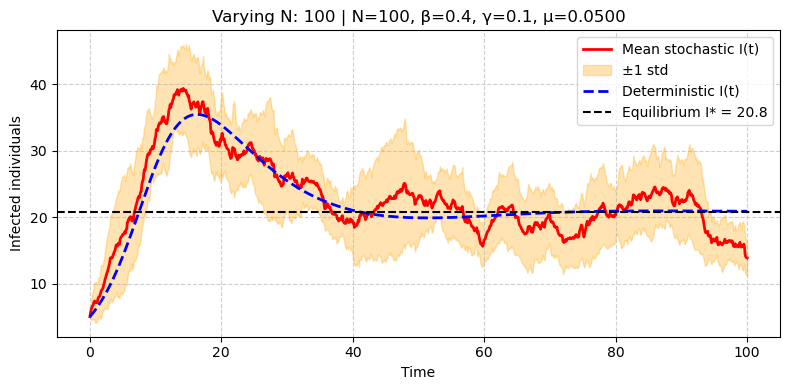

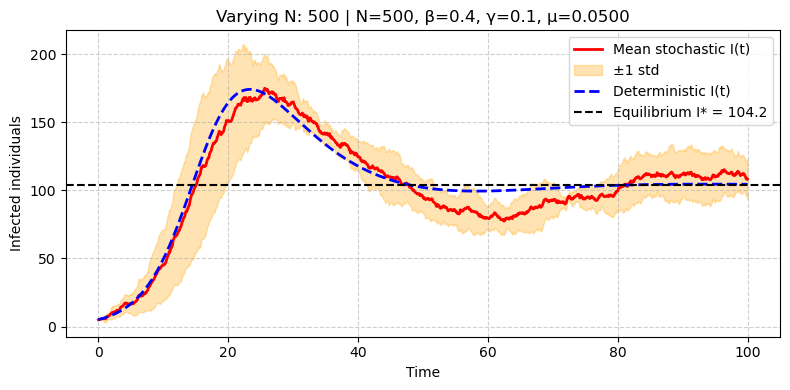

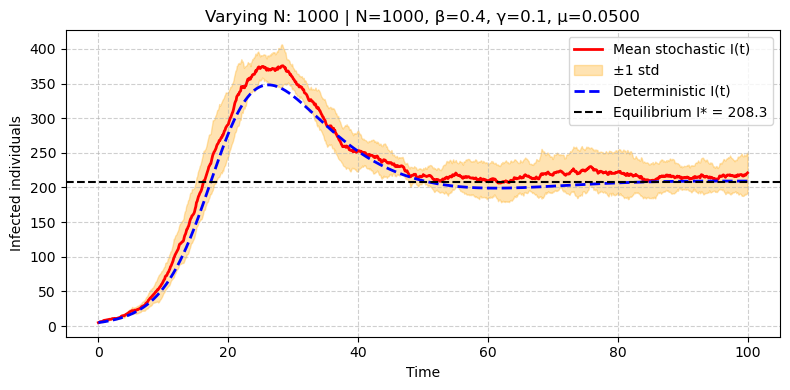

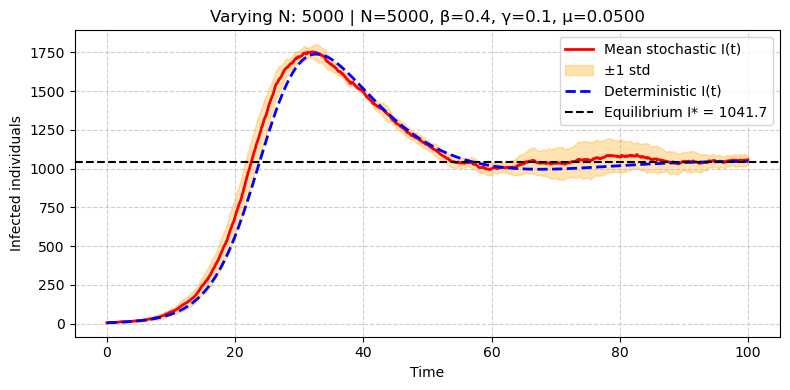

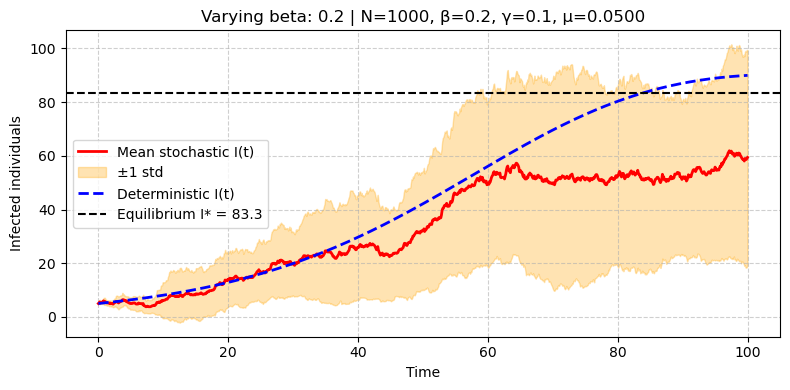

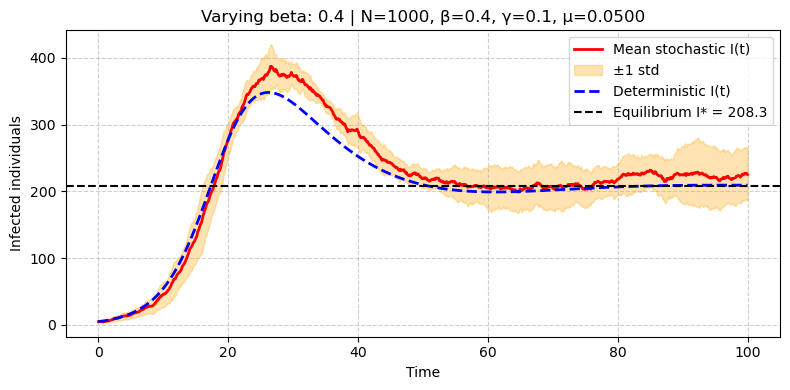

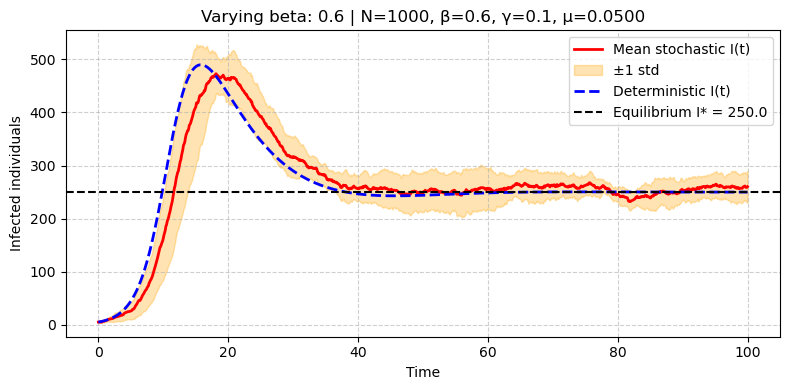

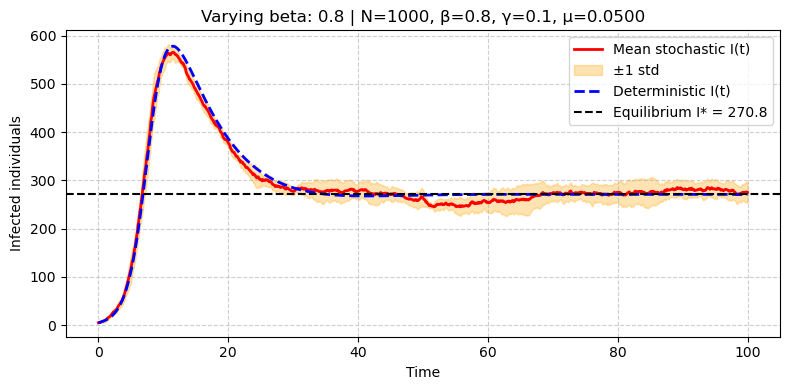

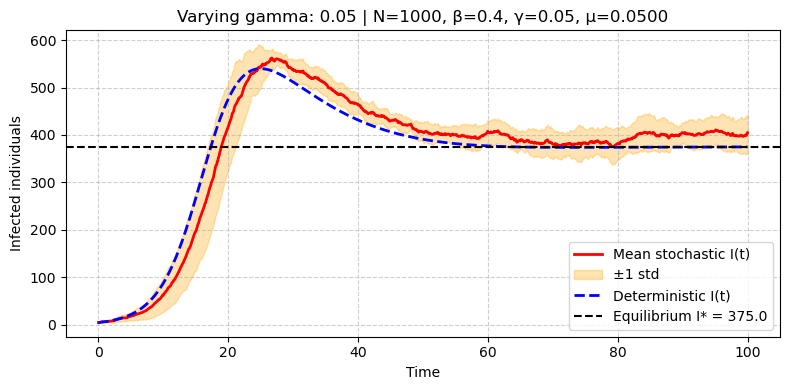

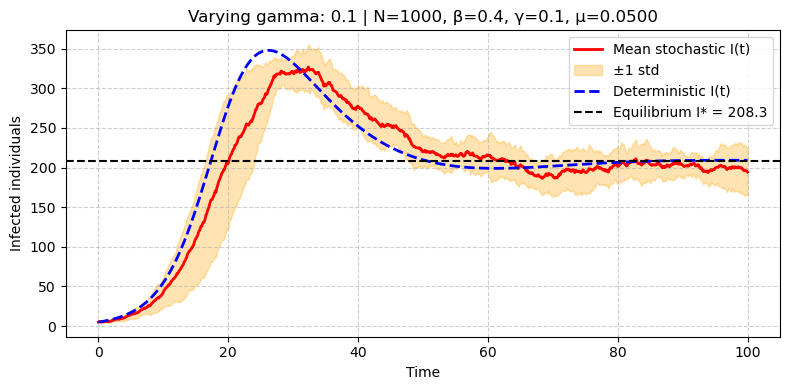

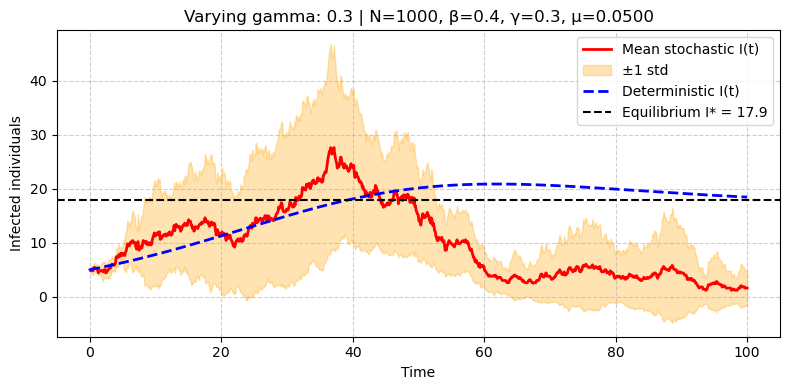

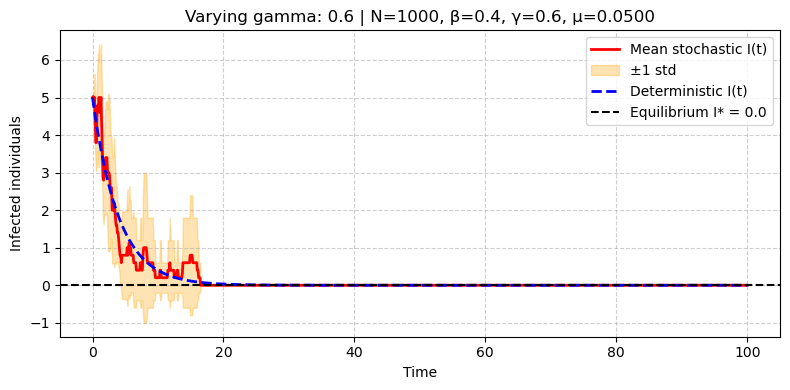

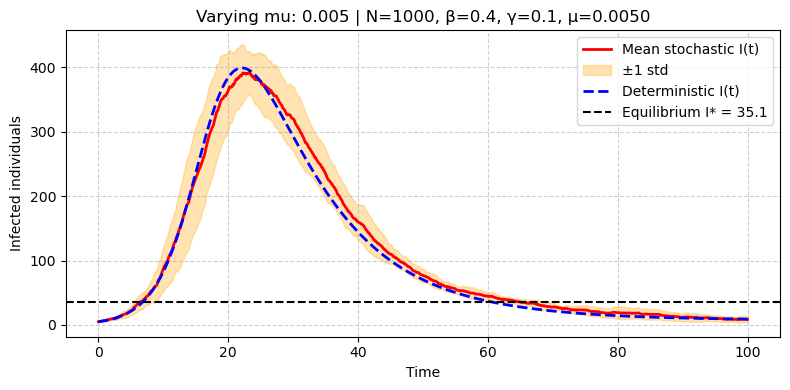

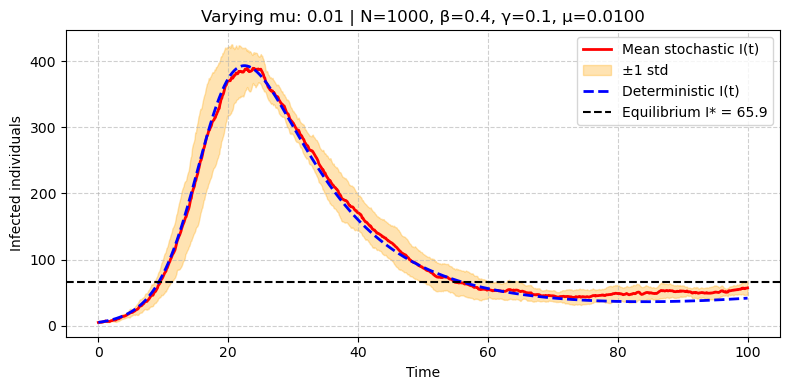

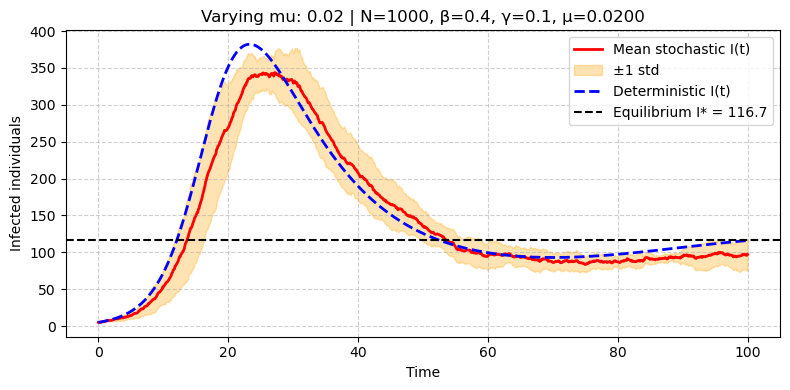

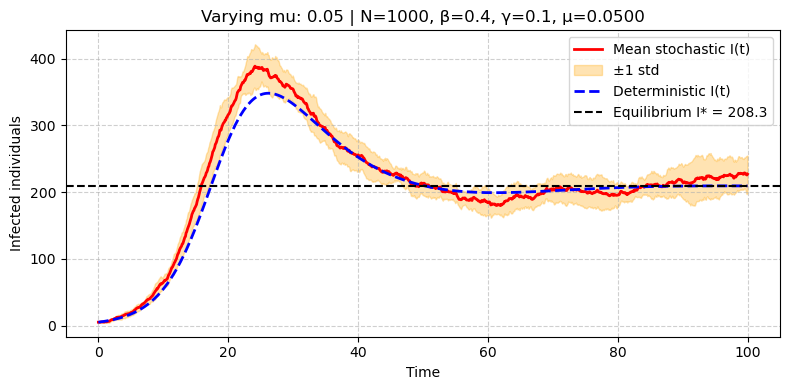

In [316]:
rng = np.random.default_rng(42)

I0 = 5
N = 1000
beta = 0.4
gamma = 0.1
mu = 0.05
t_max = 100
n_runs = 5

# --- Example 1: Vary N ---
N_values = [100, 500, 1000, 5000]
results_N, t_grid = stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng)
plot_stochastic_resonance(results_N, t_grid, N, beta, gamma, mu, vary='N')

# --- Example 2: Vary β ---
beta_values = [0.2, 0.4, 0.6, 0.8]
results_beta, t_grid = stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng)
plot_stochastic_resonance(results_beta, t_grid, N, beta, gamma, mu, vary='beta')

# --- Example 3: Vary γ ---
gamma_values = [0.05, 0.1, 0.3, 0.6]
results_gamma, t_grid = stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng)
plot_stochastic_resonance(results_gamma, t_grid, N, beta, gamma, mu, vary='gamma')

# --- Example 4: Vary μ ---
mu_values = [0.005, 0.01, 0.02, 0.05]
results_mu, t_grid = stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng)
plot_stochastic_resonance(results_mu, t_grid, N, beta, gamma, mu, vary='mu')
